solid_at_Y=0.06_max_velocity:  1.351949999999999 mm/s
air_at_Y=0.08_max_velocity:  20.2890625 mm/s
oil_at_Y=0.08_max_velocity:  12.57421875 mm/s


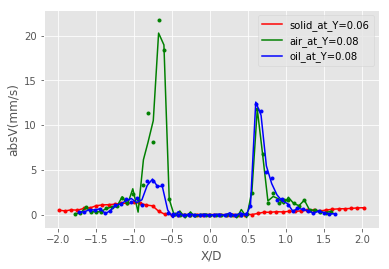

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import scipy.interpolate as si
from sklearn.base import TransformerMixin
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error

class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features

def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines




plt.style.use('ggplot')
def reg(data,mian_axis,value,count,fitnum,lintype):
    if mian_axis=="X":
        sub_axis="Y"
    else:
        sub_axis="X"
    knots = np.linspace(-2, 2, 50)
    bspline_features = BSplineFeatures(knots, degree=3, periodic=False)
    poly_model = make_pipeline(bspline_features, LinearRegression())
    df=pd.read_csv(data)
    df=df.drop(0)
    df=df.dropna(axis=1)
    df["Y"]=df["Y"].astype(float)
    df["Y"]=(df["Y"]*100).astype(int).astype(float)/100
    df["X"]=df["X"].astype(float)
    df["X"]=(df["X"]*100).astype(int).astype(float)/100
    df=df.set_index(mian_axis,drop=1)
    loc_index=df.index.unique()
    max_data=df[df.index==loc_index[count]]
    xlist=max_data[sub_axis].values
    ylist=max_data[value].values
    poly_model.fit(xlist[:,np.newaxis],ylist)
    bspline_features = BSplineFeatures(xlist[:,np.newaxis], degree=3, periodic=False)
    yfit=poly_model.predict(xlist[:,np.newaxis])
    data_type=data.split('.')
    plt.plot(xlist,ylist,'.',color=lintype)
    plt.plot(xlist,yfit,lintype,label=data_type[0]+"_at_"+mian_axis+"="+str(loc_index[count]))
    print(data_type[0]+"_at_"+mian_axis+"="+str(loc_index[count])+'_max_velocity: ',abs(yfit).max(),"mm/s")
    #return yfit,ylist,xlist;
    

fig,ax=plt.subplots()
axis="Y"
if axis=="Y":
    axis2="X"
else:
    axis2="Y"

value="absV"    
reg("solid.csv",axis,value,1,10,'r')
reg("air.csv",axis,value,2,10,'g')
reg("oil.csv",axis,value,2,10,'b')
ax.set_xlabel(axis2+'/D')
ax.set_ylabel(value+'(mm/s)')
ax.legend()



